In [1]:
from datetime import date

# tratamiento de los datos
# ============================================
import pandas as pd
import numpy as np
import sidetable
# librerías para la visualización de los datos
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer tamaño fijo de gráficas
# ==================================
plt.rcParams["figure.figsize"] = (10,8)

# Configuración warnings
# ======================
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosistest
from scipy.stats import levene
import researchpy as rp
from scipy import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Barra de progreso de un proceso
# ------------------------------------------------------------------------------
from tqdm import tqdm
# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns=None


## 🌺🌼🌷🌸 Estaciones 🌸🌷🌼🌺

In [2]:
df_original = pd.read_pickle("bicis_limpio.pickle")
df_original.head(2)

,index,date,season,year,month,holiday,weeakday,weathersit,temperature,humidity,windspeed,casual,registered,count
0,1,2018-01-01,winter,0,1,1,1,2,14.11,80.58,10.75,331,654,985
1,2,2018-01-02,winter,0,1,0,2,2,14.90,69.61,16.65,131,670,801


In [3]:
df=df_original.copy()
df.reset_index(drop=True, inplace=True)


#### Eliminamos las columnas que no necesitamos

In [4]:
df.drop(['year',"date", "index", 'weathersit'], axis=1, inplace=True)
df.head(2)

,season,month,holiday,weeakday,temperature,humidity,windspeed,casual,registered,count
0,winter,1,1,1,14.11,80.58,10.75,331,654,985
1,winter,1,0,2,14.90,69.61,16.65,131,670,801


#### Cambiamos a categorias 

In [5]:
df["month"]=df["month"].astype("category")



### Variables predictoras

#### Variables numericas

In [ ]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (20,10))
axes = axes.flat
columnas_numeric = df.select_dtypes(include = [np.number, "category"]).columns
columnas_numeric = columnas_numeric.drop(["count"])

for i, colum in enumerate(columnas_numeric): 
    sns.histplot(
        data = df,
        x = colum,
        kde = True, 
        color = "pink", 
        line_kws = {"linewidth": 2}, # para indicar el ancho de las líneas de las barras
        alpha = 0.5, # para especificar la transparencia del color
        ax = axes[i])
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout()
fig.delaxes(axes[-1])


In [ ]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (20,10))
axes = axes.flat
columnas_numeric = df.select_dtypes(include = [np.number, "category"]).columns
columnas_numeric = columnas_numeric.drop(["count"])

for i, colum in enumerate(columnas_numeric): 
    sns.boxplot(
        data = df,
        y = "count",
        x=colum,
        color = "pink", 
        ax = axes[i])
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout()
fig.delaxes(axes[-1])

plt.figure(figsize=(20,10))
sns.boxplot( 
        data = df,
        y = "count",
        x="month",
        color = "pink")

plt.figure(figsize=(20,10))
sns.boxplot( 
        data = df,
        y = "count",
        x="weathersit",
        color = "pink")

In [6]:
numericas=df.select_dtypes(include = np.number)
numericas.head()

,holiday,weeakday,temperature,humidity,windspeed,casual,registered,count
0,1,1,14.11,80.58,10.75,331,654,985
1,0,2,14.90,69.61,16.65,131,670,801
2,0,3,8.05,43.73,16.64,120,1229,1349
3,0,4,8.20,59.04,10.74,108,1454,1562
4,0,5,9.31,43.70,12.52,82,1518,1600


#### Correlación entre variables numéricas

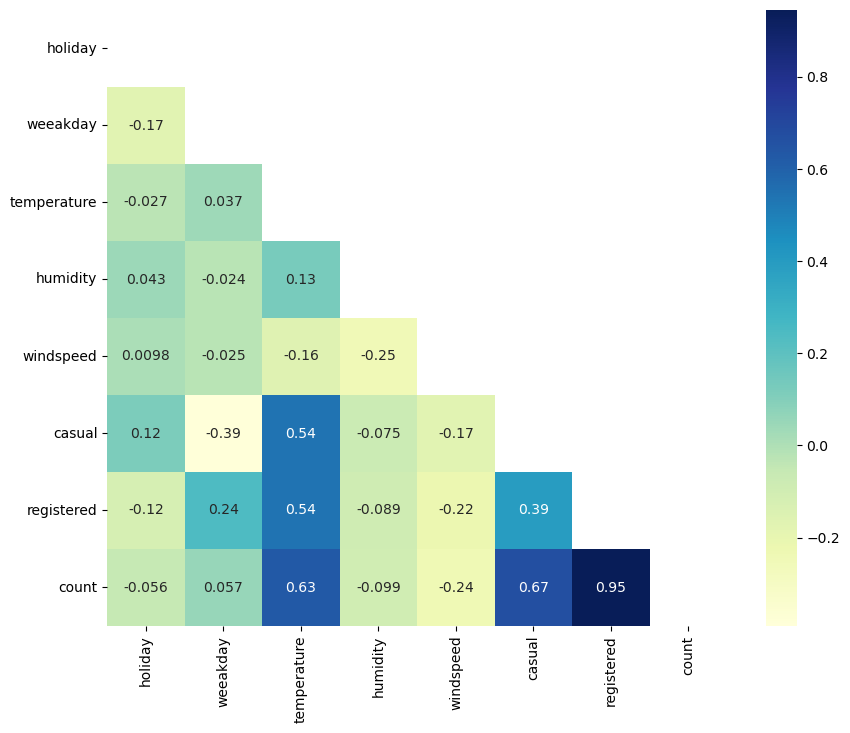

In [7]:
# creamos un dataframe todo de unos de la misma forma que nuestra matriz de correlación

mask = np.triu(np.ones_like(numericas.corr(), dtype = np.bool))

sns.heatmap(numericas.corr(), 
           cmap = "YlGnBu", 
            mask = mask,
            #v_min=-1,
            #v_max=1,
           annot = True);


# Estandarización

In [8]:
# iniciamos el método para escalar
scaler = StandardScaler()
# Eliminamos las columnas númericas que no queremos estandarizar
numericas.drop([ 'count', 'holiday', 'weeakday'], axis = 1, inplace = True)
numericas.head(2)

,temperature,humidity,windspeed,casual,registered
0,14.11,80.58,10.75,331,654
1,14.90,69.61,16.65,131,670


In [9]:
# ajustamos nuestros datos.  
scaler.fit(numericas)

StandardScaler()

In [10]:
# transformamos los datos
X_escaladas = scaler.transform(numericas)

In [11]:
# por último convertiremos el array que nos devuelve en un dataframe. 

numericas_estandar = pd.DataFrame(X_escaladas, columns = numericas.columns)
numericas_estandar.head(2)

,temperature,humidity,windspeed,casual,registered
0,-0.83,1.25,-0.39,-0.76,-1.93
1,-0.72,0.48,0.75,-1.05,-1.92


In [12]:
df[numericas_estandar.columns] = numericas_estandar
df.head()

,season,month,holiday,weeakday,temperature,humidity,windspeed,casual,registered,count
0,winter,1,1,1,-0.83,1.25,-0.39,-0.76,-1.93,985
1,winter,1,0,2,-0.72,0.48,0.75,-1.05,-1.92,801
2,winter,1,0,3,-1.64,-1.34,0.75,-1.06,-1.56,1349
3,winter,1,0,4,-1.62,-0.26,-0.39,-1.08,-1.41,1562
4,winter,1,0,5,-1.47,-1.34,-0.05,-1.12,-1.37,1600


# Arbooleees

## Encoding

In [13]:
df.reset_index(drop=True, inplace=True)
df.head(2)

,season,month,holiday,weeakday,temperature,humidity,windspeed,casual,registered,count
0,winter,1,1,1,-0.83,1.25,-0.39,-0.76,-1.93,985
1,winter,1,0,2,-0.72,0.48,0.75,-1.05,-1.92,801


In [14]:
df.reset_index(drop=True, inplace=True)
## le daremos los números más altos a aquellas categorías que sean más importantes, en este caso, al clima bueno
#mapa = {3:1,2:2,1:3} 
# aplicamos el map a nuestra columna
#df["weathersit_map"] = df["weathersit"].map(mapa)
# Columna holiday
mapa_holi={1:1,0:2}
df["holiday_map"] = df["holiday"].map(mapa_holi)
# Columna mes
mapa_mes={1:1,2:1,3:2,12:2,4:3,11:3,5:4,6:4,7:4,8:4,9:4,10:4}
df["month_map"] = df["month"].map(mapa_mes)
# Columna año
#mapa_año={0:1,1:2}
#df["year_map"] = df["year"].map(mapa_año)



In [15]:
df.weeakday.unique()

array([1, 2, 3, 4, 5, 6, 7])

In [16]:
mapa_weekday= {1:1, 2:0, 3:0, 4:1, 5:1, 6:1, 7:0}
df['weeakday_map']= df['weeakday'].map(mapa_weekday)

la columna season le hago un enconding ordinal, porque tiene orden

In [17]:
mapa_season={'winter':1,'spring':2,'autumn':2, 'summer':3}

In [18]:
df["season_map"] = df["season"].map(mapa_season)

In [19]:
# chequeamos que se hayan hecho los cambios
df.sample(4)

,season,month,holiday,weeakday,temperature,humidity,windspeed,casual,registered,count,holiday_map,month_map,weeakday_map,season_map
193,summer,7,0,5,1.37,0.03,-0.57,-0.15,-0.04,4342,2,4,1,3
86,spring,3,0,3,-1.26,-2.29,0.28,-0.91,-1.19,2028,2,2,0,2
331,autumn,11,0,3,0.04,0.81,-0.62,-0.87,-0.03,3867,2,3,0,2
203,summer,7,0,1,1.93,-0.90,-0.76,0.20,-0.87,3285,2,4,1,3


In [ ]:
#year = pd.get_dummies(df["year"], prefix_sep = "_", prefix = "year", dtype = int)
#month = pd.get_dummies(df["month"], prefix_sep = "_", prefix = "month", dtype = int)
#holiday = pd.get_dummies(df["holiday"], prefix_sep = "_", prefix = "holiday", dtype = int)
#weeakday = pd.get_dummies(df["weeakday"], prefix_sep = "_", prefix = "weeakday", dtype = int)
#season = pd.get_dummies(df["season"], prefix_sep = "_", prefix = "season", dtype = int)

In [ ]:
#df = pd.concat([df,season_map], axis = 1)
#df.head(2)

In [20]:
df.drop(["season", 'month', 'holiday', 'weeakday' ], axis=1, inplace=True)
df.head(2)

,temperature,humidity,windspeed,casual,registered,count,holiday_map,month_map,weeakday_map,season_map
0,-0.83,1.25,-0.39,-0.76,-1.93,985,1,1,1,1
1,-0.72,0.48,0.75,-1.05,-1.92,801,2,1,0,1


## Árbol

In [21]:
df.head(2)

,temperature,humidity,windspeed,casual,registered,count,holiday_map,month_map,weeakday_map,season_map
0,-0.83,1.25,-0.39,-0.76,-1.93,985,1,1,1,1
1,-0.72,0.48,0.75,-1.05,-1.92,801,2,1,0,1


In [22]:
# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y
X = df.drop(["count"], axis = 1)
y = df["count"]
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [23]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 3.
max_features = np.sqrt(len(x_train.columns))
max_features

3.0

In [24]:
# max depth
print(arbol.tree_.max_depth)

15


In [25]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [26]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [27]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,130.32,38817.54,197.02,0.99,test,Decission Tree I
1,0.00,0.00,0.00,1.00,train,Decission Tree I


In [28]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [1,2,3,4,5,6,7,8,9,10, 12, 13, 14, 15], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [20, 40, 80],
        "min_samples_leaf": [20, 40, 80]} 

In [29]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [30]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13,
                                       14, 15],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [20, 40, 80],
                         'min_samples_split': [20, 40, 80]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [31]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=7, max_features=3, min_samples_leaf=20,
                      min_samples_split=40)

In [32]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [33]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,535.37,556604.03,746.06,0.84,test,Decision tree II
1,491.09,448885.42,669.99,0.88,train,Decision tree II


In [34]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,130.32,38817.54,197.02,0.99,test,Decission Tree I
1,0.00,0.00,0.00,1.00,train,Decission Tree I
0,535.37,556604.03,746.06,0.84,test,Decision tree II
1,491.09,448885.42,669.99,0.88,train,Decision tree II


In [35]:
# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )
# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)
# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,temperature,0.46
4,registered,0.38
3,casual,0.15
1,humidity,0.01
8,season_map,0.00
6,month_map,0.00
2,windspeed,0.00
5,holiday_map,0.00
7,weeakday_map,0.00


## El Bosqueee 🌳🌲🌳🌱🌳🌲🌳🌱🌳🌲🌳🌱🌳🌲🌳🌱🌳🌲🌳

In [36]:
# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y
Xs = df.drop(["count"], axis = 1)
ys = df["count"]

In [37]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo
x_train, x_test, y_train, y_test = train_test_split(Xs, ys, test_size = 0.2, random_state = 42)

In [38]:
# recordamos que lo primero que hacíamos era crear un diccionario con los hiperparámetros que queríamos probar

param = {"max_depth": [2,4,6,8,10,12,14], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 25, 50],
        "min_samples_leaf": [10, 25, 50]} 

In [39]:
gs_rf = GridSearchCV(
            estimator=RandomForestRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [40]:
# ajustamos el modelo que acabamos de definir en el GridSearch
# 🚨 Esta celda puede tardar en ejecutarse

gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 25, 50],
                         'min_samples_split': [10, 25, 50]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [41]:
# al igual que el decision tree podemos sacar cual es nuestro mejor bosque
# En este caso,  nuestro mejor bosque es aquel que esta formado por arboles de 6 de profundidad, usa 4 variables y que tiene  un min_samples_leaf y un min_samples_split de 10. 

bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=14, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

In [42]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [43]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [44]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
dt_results

,MAE,MSE,RMSE,R2,set,modelo
0,191.09,75465.49,274.71,0.98,test,Random Forest
1,171.34,67476.86,259.76,0.98,train,Random Forest


In [45]:
# vamos a crearnos un dataframe, igual que hicimos en la clase anterior con la importancia de cada una de las variables incluidas en el modelo

importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': bosque.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
4,registered,0.60
3,casual,0.23
0,temperature,0.11
6,month_map,0.03
8,season_map,0.02
1,humidity,0.01
2,windspeed,0.01
7,weeakday_map,0.00
5,holiday_map,0.00


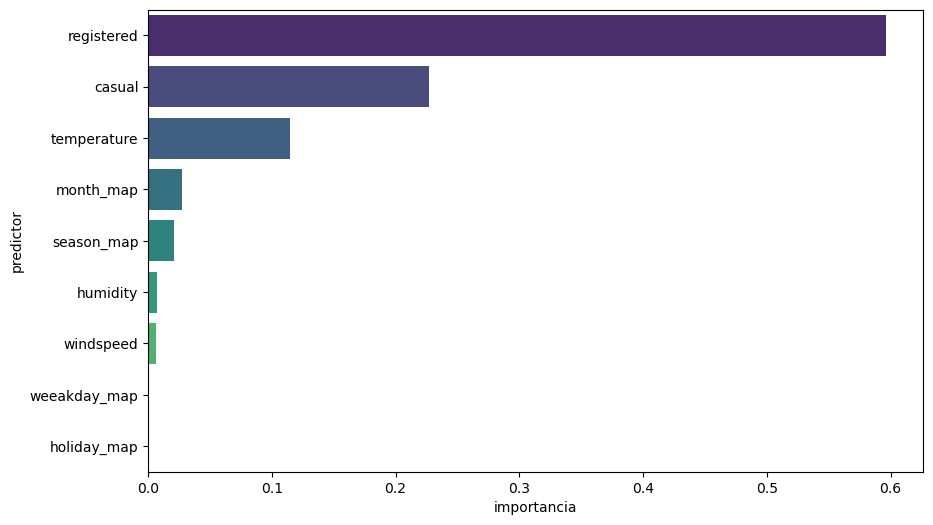

In [46]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()